In [23]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
import jax.numpy as jnp
from jax.experimental import host_callback
from tqdm.auto import tqdm
from functools import partial
import frozen_lake
import plotting
import qlearning
import actions
import utils

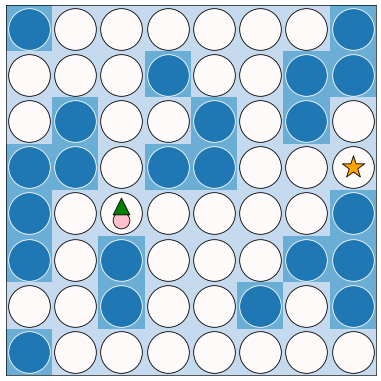

In [24]:
key = jax.random.PRNGKey(42)
scale = 3
  
env = frozen_lake.FrozenLake.make_random(key, scale, 0.5)
state, obs = env.reset(key)
plotting.render(env, state)

In [25]:
from flax import linen as nn

n_comands = 5
cell_scale = 1

MultiMLP = nn.vmap(
    utils.MLP,
    in_axes=None,  # type: ignore
    variable_axes={"params": 0},
    split_rngs={"params": True},
    axis_size=n_comands,
)

In [26]:
reward_fn = partial(actions.reward_fn, cell_scale)
beta_fn = partial(actions.beta_fn, cell_scale)

qnet = MultiMLP(env.action_space.n)
dql_state = qlearning.MultiDQLTrainState.create(
    key, qnet, env, reward_fn=reward_fn, beta_fn=beta_fn
)

max_steps = 2**20
rollout_steps = 128
n_rollouts = max_steps // rollout_steps
batch_size = 8 * rollout_steps


def sim_step(dql_state, rng_key, pbar):
    rng_expl, rng_train, rng_eval = host_callback.id_tap(
        lambda a, t: pbar.update(1), jax.random.split(rng_key, 3)
    )

    transitions = utils.random_rollout(env, rng_expl, rollout_steps)
    dql_state = dql_state.update_replay(transitions)

    transitions = dql_state.replay_buffer.sample(rng_train, batch_size)
    transitions = dql_state.process_transitions(transitions)
    dql_state = dql_state.update_params(transitions)
    return dql_state, None

In [27]:
rng_key = jax.random.PRNGKey(42)
rng_steps = jax.random.split(rng_key, n_rollouts)
pbar = tqdm(range(n_rollouts))
dql_state, rewards = jax.lax.scan(partial(sim_step, pbar=pbar), dql_state, rng_steps)

  0%|          | 0/8192 [00:00<?, ?it/s]

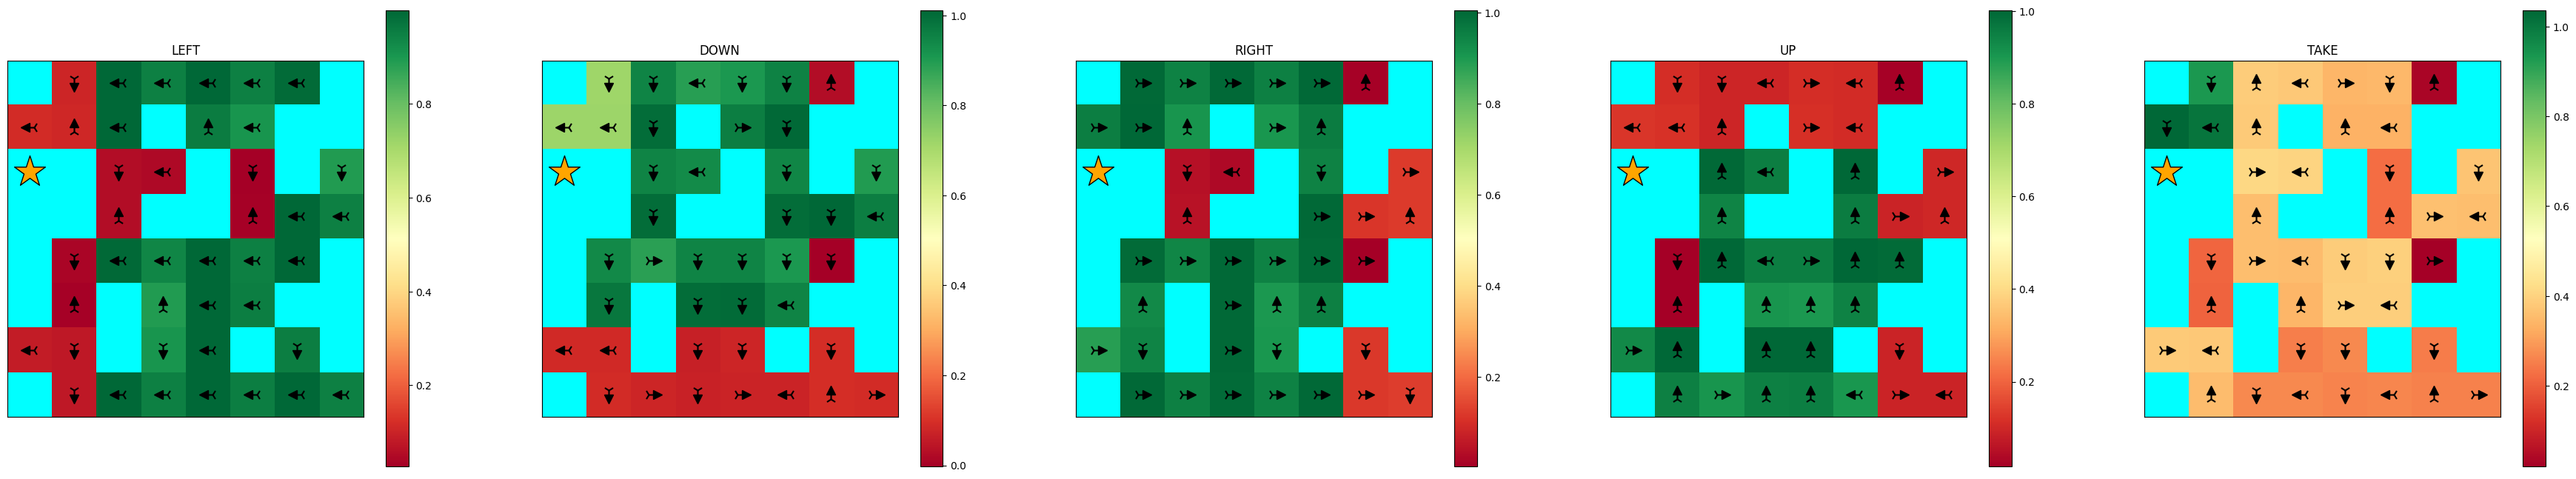

In [28]:
get_qval_fn = jax.jit(lambda obs: dql_state.qval_apply_fn(dql_state.params_qnet, obs))
plotting.plot_qvals(env, get_qval_fn, tasks=["LEFT", "DOWN", "RIGHT", "UP", "TAKE"])